## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# print features + target
print(data.columns)
print(len(data.columns))

# display data
data.head()

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')
14


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [4]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [5]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [6]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [7]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [8]:
# save the data set
data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [9]:
target = 'survived'

In [10]:
print(data.columns)
print(len(data.columns))

Index(['pclass', 'survived', 'sex', 'age', 'sibsp', 'parch', 'fare', 'cabin',
       'embarked', 'title'],
      dtype='object')
10


In [11]:
vars_cat = [var for var in data.columns if data[var].dtype == 'O']
print(f"Categorial variables: {vars_cat}")
print('Number of categorical variables: {}'.format(len(vars_cat)), '\n')

vars_num = [var for var in data.columns if var not in vars_cat and var != target]
print(f"Numerical variables: {vars_num}")
print('Number of numerical variables: {}'.format(len(vars_num)))


Categorial variables: ['sex', 'cabin', 'embarked', 'title']
Number of categorical variables: 4 

Numerical variables: ['pclass', 'age', 'sibsp', 'parch', 'fare']
Number of numerical variables: 5


### Find missing values in variables

In [12]:
# first in numerical variables

# make a list of the variables that contain missing values
vars_num_with_na = [var for var in vars_num if data[var].isnull().sum() > 0]

print(f"Numerical variables with missing values: {vars_num_with_na}")

# determine percentage of missing values (expressed as decimals)
# and display the result ordered by % of missin data
data[vars_num_with_na].isnull().mean().sort_values(ascending=False)

Numerical variables with missing values: ['age', 'fare']


age     0.200917
fare    0.000764
dtype: float64

In [13]:
# now in categorical variables

# make a list of the variables that contain missing values
vars_cat_with_na = [var for var in vars_cat if data[var].isnull().sum() > 0]

print(f"Categorial variables with missing values: {vars_cat_with_na}")

# determine percentage of missing values (expressed as decimals)
# and display the result ordered by % of missin data

data[vars_cat_with_na].isnull().mean().sort_values(ascending=False)

Categorial variables with missing values: ['cabin', 'embarked']


cabin       0.774637
embarked    0.001528
dtype: float64

### Determine cardinality of categorical variables

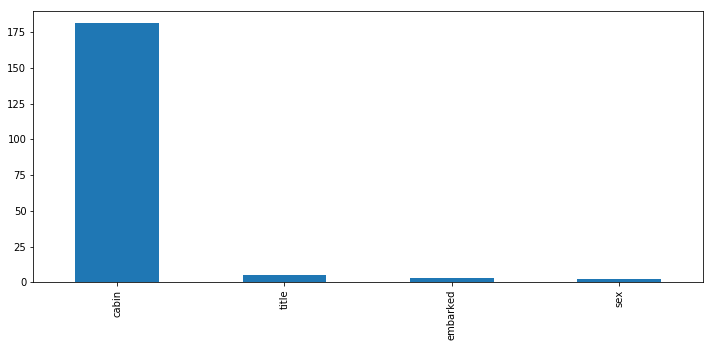

In [14]:
# we count unique categories with pandas unique() 
# and then plot them in descending order

data[vars_cat].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

### Determine the distribution of numerical variables

In [15]:
print(vars_num)

['pclass', 'age', 'sibsp', 'parch', 'fare']


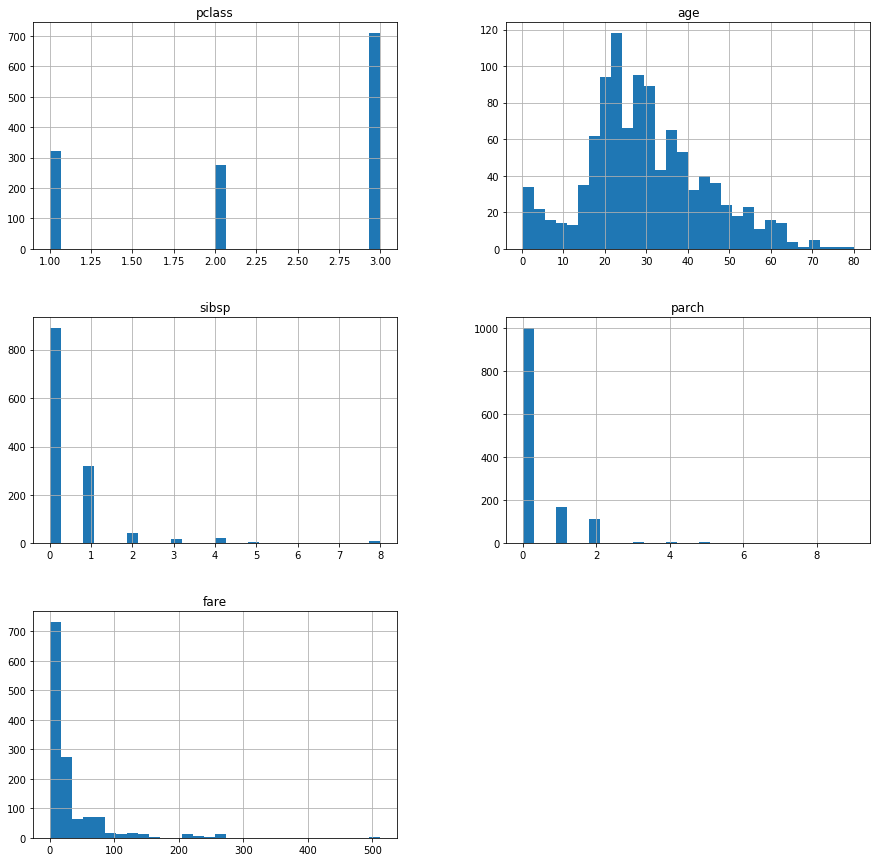

In [16]:
# lets plot histograms for all nymerical variables

data[vars_num].hist(bins=30, figsize=(15,15))
plt.show()

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(target, axis=1),  # predictors
    data[target],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [18]:
def del_number(cabin):
    try:
        return ''.join([i for i in cabin if not i.isdigit()])
    except TypeError:
        return cabin

In [19]:
X_train['cabin'] = X_train['cabin'].apply(del_number)
X_test['cabin'] = X_test['cabin'].apply(del_number)

In [20]:
X_train['cabin'].head(100)

1118    NaN
44        E
1072    NaN
1130    NaN
574     NaN
       ... 
613     NaN
1076    NaN
740     NaN
808     NaN
351     NaN
Name: cabin, Length: 100, dtype: object

In [21]:
X_test['cabin'].head(10)

1139    NaN
533     NaN
459     NaN
1150    NaN
393     NaN
1189      G
5         E
231       C
330     NaN
887     NaN
Name: cabin, dtype: object

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [22]:
# replace missing values as we described above

for var in vars_num_with_na:
    # calculate the mean using the train set
    median_val = X_train[var].median()
    
    print(var, median_val)

    # add binary missing indicator (in train and test)
    X_train[var + '_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var + '_na'] = np.where(X_test[var].isnull(), 1, 0)

    # replace missing values by the mean
    # (in train and test)
    X_train[var].fillna(median_val, inplace=True)
    X_test[var].fillna(median_val, inplace=True)

age 28.0
fare 14.4542


In [23]:
# check that we have no more missing values in the engineered variables
print(X_train[vars_num_with_na].isnull().sum())
print(X_test[vars_num_with_na].isnull().sum())

age     0
fare    0
dtype: int64
age     0
fare    0
dtype: int64


### Replace Missing data in categorical variables with the string **Missing**

In [24]:
# cast all variables as categorical
X_train[vars_cat] = X_train[vars_cat].astype('O')
X_test[vars_cat] = X_test[vars_cat].astype('O')

In [25]:
X_train[vars_cat_with_na] = X_train[vars_cat_with_na].fillna('Missing')
X_test[vars_cat_with_na] = X_test[vars_cat_with_na].fillna('Missing')

In [26]:
# check that we have no missing information in the engineered variables
print(X_train[vars_cat_with_na].isnull().sum())
print(X_test[vars_cat_with_na].isnull().sum())

cabin       0
embarked    0
dtype: int64
cabin       0
embarked    0
dtype: int64


### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [27]:
def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are shared by more than
    # a certain % of the houses in the dataset

    df = df.copy()

    tmp = df.groupby(var)[var].count() / len(df)

    return tmp[tmp > rare_perc].index

In [28]:
for var in vars_cat:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.05)
    
    print(var, frequent_ls)
    print()
    
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')

sex Index(['female', 'male'], dtype='object', name='sex')

cabin Index(['C', 'Missing'], dtype='object', name='cabin')

embarked Index(['C', 'Q', 'S'], dtype='object', name='embarked')

title Index(['Miss', 'Mr', 'Mrs'], dtype='object', name='title')



### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [29]:
vars_cat

['sex', 'cabin', 'embarked', 'title']

In [30]:
def OHE(df_input, var):
    # Apply one-hot-encoding to the categorial variables

    df_input = df_input.copy()

    df_output = pd.get_dummies(df_input[var], prefix=var)

    return df_output

In [31]:
for var in vars_cat:
    X_train_ohe = OHE(X_train, var)
    
    X_test_ohe = OHE(X_test, var)
    
    X_train = pd.concat([X_train, X_train_ohe], axis=1)
    X_test = pd.concat([X_test, X_test_ohe], axis=1)
    
    X_train = X_train.drop([var], axis=1)
    X_test = X_test.drop([var], axis=1)

In [32]:
print(X_train.columns)
print(X_train.columns.shape)
print(X_test.columns)
print(X_test.columns.shape)

Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'age_na', 'fare_na',
       'sex_female', 'sex_male', 'cabin_C', 'cabin_Missing', 'cabin_Rare',
       'embarked_C', 'embarked_Q', 'embarked_Rare', 'embarked_S', 'title_Miss',
       'title_Mr', 'title_Mrs', 'title_Rare'],
      dtype='object')
(20,)
Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'age_na', 'fare_na',
       'sex_female', 'sex_male', 'cabin_C', 'cabin_Missing', 'cabin_Rare',
       'embarked_C', 'embarked_Q', 'embarked_S', 'title_Miss', 'title_Mr',
       'title_Mrs', 'title_Rare'],
      dtype='object')
(19,)


In [33]:
X_train.head()

,pclass,age,sibsp,parch,fare,age_na,fare_na,sex_female,sex_male,cabin_C,cabin_Missing,cabin_Rare,embarked_C,embarked_Q,embarked_Rare,embarked_S,title_Miss,title_Mr,title_Mrs,title_Rare
1118,3,25.0,0,0,7.9250,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0
44,1,41.0,0,0,134.5000,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0
1072,3,28.0,0,0,7.7333,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0
1130,3,18.0,0,0,7.7750,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0
574,2,29.0,1,0,21.0000,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0


In [34]:
X_test.head()

,pclass,age,sibsp,parch,fare,age_na,fare_na,sex_female,sex_male,cabin_C,cabin_Missing,cabin_Rare,embarked_C,embarked_Q,embarked_S,title_Miss,title_Mr,title_Mrs,title_Rare
1139,3,38.0,0,0,7.8958,0,0,0,1,0,1,0,0,0,1,0,1,0,0
533,2,21.0,0,1,21.0000,0,0,1,0,0,1,0,0,0,1,1,0,0,0
459,2,42.0,1,0,27.0000,0,0,0,1,0,1,0,0,0,1,0,1,0,0
1150,3,28.0,0,0,14.5000,1,0,0,1,0,1,0,0,0,1,0,1,0,0
393,2,25.0,0,0,31.5000,0,0,0,1,0,1,0,0,0,1,0,1,0,0


In [35]:
# we add 0 as values for all the observations, as Rare
# was not present in the test set

X_test['embarked_Rare'] = 0

In [36]:
# Note that now embarked_Rare will be at the end of the test set
# so in order to pass the variables in the same order, we will
# create a variables variable:

variables = [c  for c in X_train.columns]

variables

['pclass',
 'age',
 'sibsp',
 'parch',
 'fare',
 'age_na',
 'fare_na',
 'sex_female',
 'sex_male',
 'cabin_C',
 'cabin_Missing',
 'cabin_Rare',
 'embarked_C',
 'embarked_Q',
 'embarked_Rare',
 'embarked_S',
 'title_Miss',
 'title_Mr',
 'title_Mrs',
 'title_Rare']

### Scale the variables

- Use the standard scaler from Scikit-learn

In [37]:
# create scaler
scaler = StandardScaler()

#  fit  the scaler to the train set
scaler.fit(X_train[variables]) 

# transform the train and test set

# sklearn returns numpy arrays, so we wrap the
# array with a pandas dataframe

X_train = pd.DataFrame(
    scaler.transform(X_train[variables]),
    columns=X_train.columns
)

X_test = pd.DataFrame(
    scaler.transform(X_test[variables]),
    columns=X_test.columns
)

/home/etagiev/.local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/etagiev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  del sys.path[0]
/home/etagiev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


In [38]:
X_train.head()

,pclass,age,sibsp,parch,fare,age_na,fare_na,sex_female,sex_male,cabin_C,cabin_Missing,cabin_Rare,embarked_C,embarked_Q,embarked_Rare,embarked_S,title_Miss,title_Mr,title_Mrs,title_Rare
0,0.835808,-0.370162,-0.478911,-0.455423,-0.504782,-0.494921,-0.03092,-0.761042,0.761042,-0.283717,0.551235,-0.434076,-0.493425,-0.319539,-0.043748,0.639650,-0.500895,0.869892,-0.435629,-0.275778
1,-1.542157,0.904029,-0.478911,-0.455423,1.971555,-0.494921,-0.03092,1.313987,-1.313987,-0.283717,-1.814107,2.303742,2.026652,-0.319539,-0.043748,-1.563355,1.996425,-1.149569,-0.435629,-0.275778
2,0.835808,-0.131251,-0.478911,-0.455423,-0.508533,2.020526,-0.03092,-0.761042,0.761042,-0.283717,0.551235,-0.434076,-0.493425,3.129507,-0.043748,-1.563355,-0.500895,0.869892,-0.435629,-0.275778
3,0.835808,-0.927621,-0.478911,-0.455423,-0.507717,-0.494921,-0.03092,1.313987,-1.313987,-0.283717,0.551235,-0.434076,-0.493425,-0.319539,-0.043748,0.639650,1.996425,-1.149569,-0.435629,-0.275778
4,-0.353174,-0.051614,0.434422,-0.455423,-0.248980,-0.494921,-0.03092,-0.761042,0.761042,-0.283717,0.551235,-0.434076,-0.493425,-0.319539,-0.043748,0.639650,-0.500895,0.869892,-0.435629,-0.275778


## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [39]:
clf = LogisticRegression(random_state=0, C=0.0005)
clf.fit(X_train, y_train)

/home/etagiev/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.0005, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [40]:
# make predictions for test set
class_ = clf.predict(X_train)
pred = clf.predict_proba(X_train)[:,1]

# determine mse and rmse
print('train roc-auc: {}'.format(roc_auc_score(y_train, pred)))
print('train accuracy: {}'.format(accuracy_score(y_train, class_)))
print()

# make predictions for test set
class_ = clf.predict(X_test)
pred = clf.predict_proba(X_test)[:,1]

# determine mse and rmse
print('test roc-auc: {}'.format(roc_auc_score(y_test, pred)))
print('test accuracy: {}'.format(accuracy_score(y_test, class_)))
print()

train roc-auc: 0.8442619783616693
train accuracy: 0.7803247373447947

test roc-auc: 0.8396604938271606
test accuracy: 0.7709923664122137



That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**